In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json('/shared/0/projects/research-jam-summer-2024/data/regression_100k_data/merged_metrics_with_dicts_397k.jsonl', orient='records', lines=True)

In [ ]:
#new column titled 'category' - argmax all
category_columns = [col for col in df.columns if col.startswith('category_')]

df['max_cat'] = df[category_columns].max(axis=1)

In [ ]:
df.columns.tolist()

In [ ]:
df['max_cat'][:2]

In [ ]:
features = df.columns.tolist()

#remove non-floats
for col in df.columns:
    if not df[col].apply(lambda x: isinstance(x, float)).all():
        features.remove(col)

#remove anything starting with agg_ or metric_
features = [item for item in features if not (item.startswith('agg_') or item.startswith('metric_') or item.startswith('category_'))]
features.remove('overall_score')
features

In [ ]:
def perform_regression(data, X_cols, y_col):
    results = StringIO()
    
    data.dropna(subset=X_cols + [y_col], inplace=True)
    X = data[X_cols]
    y = data[[y_col]]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    results.write(model.summary().as_text())
    results.write("\n")
    
    
    return results.getvalue(), model


def backward_stepwise(data, X_cols, y_col):
    while len(X_cols) > 0:
        _, model = perform_regression(data, X_cols, y_col)
        p_values = model.pvalues
        max_p_value = p_values.max()
        
        if max_p_value < 0.05:  
            break
        
        max_p_variable = p_values.idxmax()
        if max_p_variable == 'const': 
            p_values = p_values.drop('const')
            max_p_variable = p_values.idxmax()
        
        X_cols.remove(max_p_variable)
    
    return model, X_cols

In [ ]:
#check correlation matrix between all features - eliminate > 0.8

correlation_matrix = df[features].corr()
correlation_matrix


In [ ]:
for idx in range(len(correlation_matrix.columns)):
    for jdx in range(idx + 1, len(correlation_matrix.columns)):  
        if abs(correlation_matrix.iloc[idx, jdx]) >= 0.8:
            row = correlation_matrix.columns[idx]
            col = correlation_matrix.columns[jdx]
            print(f'Row: {row}')
            print(f'Col: {col}')
            print(f'Correlation: {correlation_matrix.iloc[idx, jdx]}')
            print('\n')

In [ ]:
from io import StringIO
data = df[:1000]
import statsmodels.api as sm

results = []
X_cols = features.copy()
y_col = 'overall_score'
model, final_X_cols = backward_stepwise(data.copy(), X_cols, y_col)
results.append((model, final_X_cols, y_col))

with open("backwards_elim.txt", "w") as output_file:
    for model, X_cols, y_col in results:
        results, model = perform_regression(df.copy(), X_cols.copy(), y_col)
        output_file.write(model.summary().as_text())
        output_file.write("\n" + "="*80 + "\n\n")


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

from io import StringIO
data = df[:1000]
import statsmodels.api as sm

results = []
X_cols = features.copy()
y_col = 'overall_score'
results, model = perform_regression(df.copy(), X_cols.copy(), y_col)

with open('full_regression.txt', 'w') as out:
    out.write(results)
print(results)


In [ ]:
df_features = df[features]

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
from collections import Counter

In [2]:
os.chdir('/shared/0/projects/research-jam-summer-2024')
df = pd.read_json('data/regression_100k_data/merged_metrics_with_dicts_397k.jsonl', orient='records', lines=True)

In [3]:
df.columns.tolist()

['agg_zscore_lexical',
 'agg_zscore_semantic',
 'agg_zscore_style',
 'agg_zscore_syntactic',
 'conversation_hash',
 'hashed_ip',
 'llm_model',
 'overall_zscore_score',
 'prompt',
 'model',
 'country',
 'language',
 'turn',
 'toxic',
 'topic0',
 'topic1',
 'topic2',
 'topic3',
 'topic4',
 'topic5',
 'topic6',
 'topic7',
 'topic8',
 'topic9',
 'topic10',
 'topic11',
 'topic12',
 'topic13',
 'topic14',
 'topic15',
 'topic16',
 'topic17',
 'topic18',
 'topic19',
 'topic20',
 'topic21',
 'topic22',
 'topic23',
 'topic24',
 'topic25',
 'topic26',
 'topic27',
 'topic28',
 'topic29',
 'topic30',
 'topic31',
 'topic32',
 'topic33',
 'topic34',
 'topic35',
 'topic36',
 'topic37',
 'topic38',
 'topic39',
 'topic40',
 'topic41',
 'topic42',
 'topic43',
 'topic44',
 'topic45',
 'topic46',
 'topic47',
 'topic48',
 'topic49',
 'ai_turn_2_capitalization',
 'ai_turn_2_contract_count',
 'ai_turn_2_formality',
 'ai_turn_2_liwc',
 'ai_turn_2_log_word_count',
 'ai_turn_2_perplexity',
 'ai_turn_2_politeness

In [4]:
Counter(df['human_turn_1_topic'].apply(lambda x: round(sum(x),4) if x!=None else 0))

Counter({1.0: 298927, 0.0: 13})

In [5]:
from copy import deepcopy
df1 = deepcopy(df)

In [6]:
url = "https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
country_region = pd.read_csv(url)
country_region.head()
import re
country_region.name = country_region.name.apply(lambda x: re.sub(',.*','',x))
country_region.loc[country_region['alpha-2']=='KP','name'] = 'South Korea'
country_region.loc[country_region['alpha-2']=='CD','name'] = 'DR Congo'
country_region.loc[country_region['name']=='Taiwan','region'] = 'Asia'
country_region.loc[country_region['name']=='Taiwan','sub-region'] = 'Eastern Asia'
df1.country = df1.country.replace({'United States':'United States of America',
                                 'Russia':'Russian Federation',
                                 'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
                                 'The Netherlands': 'Netherlands',
                                 'Vietnam': 'Viet Nam',
                                 'Syria': 'Syrian Arab Republic',
                                 'Laos': "Lao People's Democratic Republic"})
df1 = df1.merge(country_region[['name','sub-region','region']], 
                left_on='country', right_on='name', how='left')
df1.loc[df1.country=='Kosovo','region'] = 'Europe'
df1.loc[df1.country=='Kosovo','sub-region'] = 'Southern Europe'
df1.loc[df1.country=='United States of America','sub-region'] = 'United States'
df1.loc[df1.country=='United States of America','region'] = 'United States'
df1 = df1.drop(['name','country','region'], axis=1)

Counter(df1['sub-region'])
df1.loc[df1['sub-region']=='Polynesia','sub-region'] = 'Melanesia'
Counter(df1['sub-region'])
df1 = df1.rename(columns={'sub-region':'subregion'})
#df1 = df1.loc[:,~df1.columns.str.startswith('agg_')]
#df1 = df1.loc[:,~df1.columns.str.startswith('metric_')]
df1.columns
df1 = df1.drop(['conversation_hash', 'hashed_ip', 'language',
                          'human_turn_1_liwc', 'human_turn_1_pos', 'human_turn_1_punctuation','human_turn_1_topic',
                          'ai_turn_2_liwc', 'ai_turn_2_pos', 'ai_turn_2_punctuation','ai_turn_2_topic'], axis=1)
df1.columns
#no need to log-scale turn
df1['human_turn_1_perplexity'] = np.log(df1['human_turn_1_perplexity'])
df1['ai_turn_2_perplexity'] = np.log(df1['ai_turn_2_perplexity'])

In [7]:
df1 = df1.drop(['topic9','category_1'], axis=1)
df2 = deepcopy(df1)

In [8]:
df2['category'] = df2.loc[:,df2.columns.str.contains('category_')].idxmax(axis=1)
Counter(df2['category'])
df2 = df2.loc[:,~df2.columns.str.contains('category_')]
df2['lda'] = df2.loc[:,df2.columns.str.startswith('topic')].idxmax(axis=1)
Counter(df2['lda'])
df2 = df2.loc[:,~df2.columns.str.startswith('topic')]
df2.columns

label2id = {
    "analysis or decision explanation": 0,
    "assisting or creative writing": 1,
    "classification": 2,
    "coding": 3,
    "editing or rewriting": 4,
    "factual information (general or professional), history or common practices": 5,
    "information extraction or summarization": 6,
    "linguistics": 7,
    "logical reasoning": 8,
    "mathematical reasoning or calculation": 9,
    "multilinguality or translation": 10,
    "other": 11,
    "recommendation": 12,
    "roleplay": 13,
    "tips, opinions or advice": 14
  }
label2id = {
    "analysis": 0,
    "writing": 1,
    "classification": 2,
    "coding": 3,
    "editing": 4,
    "information": 5,
    "infoextraction": 6,
    "linguistics": 7,
    "logic": 8,
    "math": 9,
    "multilingual": 10,
    "other": 11,
    "recommendation": 12,
    "roleplay": 13,
    "tips": 14
  }
cats = {'category_'+str(label2id[k]): k for k in label2id}
len(cats)

df1 = df1.rename(columns = {k:'cat_'+v for k,v in cats.items()})
df2.category = df2.category.replace(cats)

/tmp/ipykernel_1919832/1845168913.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df2['category'] = df2.loc[:,df2.columns.str.contains('category_')].idxmax(axis=1)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calculate_vif(dataframe):
    numeric_df = dataframe#.select_dtypes(include=[np.number])
    
    numeric_df = numeric_df.dropna()

    numeric_df = add_constant(numeric_df)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, j) 
                       for j in range(numeric_df.shape[1])]
    
    print("VIF Values for each variable:")
    print(vif_data)
    print("\n")
    
    high_vif = vif_data[vif_data["VIF"] > 4]
    if not high_vif.empty:
        print("Variables with high multicollinearity (VIF > 10):")
        print(high_vif)
        return high_vif
    else:
        print("No variables with high multicollinearity detected.")

In [ ]:
from statsmodels.tools.tools import add_constant
from itertools import combinations
vars_to_drop = ['overall_score']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').drop(vars_to_drop,axis=1).dropna().sample(1000, random_state=0)
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
high_vif = calculate_vif(numeric_df)

In [ ]:
high_vif

In [ ]:
high_vif['VIF'].max()

In [ ]:
df2.columns.tolist()

In [ ]:
vars_to_drop = ['overall_score']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').drop(vars_to_drop,axis=1).dropna().sample(10000, random_state=0) 
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
high_vif = calculate_vif(numeric_df)

In [ ]:
vars_to_drop = ['overall_score', 'lda_topic9']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').drop(vars_to_drop,axis=1).dropna().sample(10000, random_state=0) 
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
high_vif = calculate_vif(numeric_df)

In [ ]:
vars_to_drop = ['overall_score', 'lda_topic9', 'model_gpt-3.5-turbo-0613']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').drop(vars_to_drop,axis=1).dropna().sample(10000, random_state=0) 
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
high_vif = calculate_vif(numeric_df)

In [ ]:
test_feat = ['subregion_United States', 'lda_topic9']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').sample(10000, random_state=0) 
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
numeric_df.columns.tolist
correlation = numeric_df[test_feat].corr().iloc[0, 1]

correlation

In [ ]:
numeric_df.columns.tolist()

In [ ]:
test_feat = ['human_turn_1_toxicity', 'lda_topic9']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').sample(10000, random_state=0) 
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
numeric_df.columns.tolist
correlation = numeric_df[test_feat].corr().iloc[0, 1]

correlation

In [ ]:
test_feat = ['ai_turn_2_toxicity', 'lda_topic9']
numeric_df = pd.get_dummies(df2, drop_first=True, dtype='int').sample(10000, random_state=0) 
numeric_df.toxic = numeric_df.toxic.apply(lambda x: 1 if x else 0)
numeric_df.columns.tolist
correlation = numeric_df[test_feat].corr().iloc[0, 1]

correlation

In [9]:
import re
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [10]:
all_cols = df2.columns.tolist()
all_cols

['agg_zscore_lexical',
 'agg_zscore_semantic',
 'agg_zscore_style',
 'agg_zscore_syntactic',
 'llm_model',
 'overall_zscore_score',
 'prompt',
 'model',
 'turn',
 'toxic',
 'ai_turn_2_capitalization',
 'ai_turn_2_contract_count',
 'ai_turn_2_formality',
 'ai_turn_2_log_word_count',
 'ai_turn_2_perplexity',
 'ai_turn_2_politeness',
 'ai_turn_2_readability',
 'ai_turn_2_sentiment',
 'ai_turn_2_subjectivity',
 'ai_turn_2_toxicity',
 'ai_turn_2_typo',
 'ai_turn_2_word_length',
 'human_turn_1_capitalization',
 'human_turn_1_contract_count',
 'human_turn_1_formality',
 'human_turn_1_log_word_count',
 'human_turn_1_perplexity',
 'human_turn_1_politeness',
 'human_turn_1_readability',
 'human_turn_1_sentiment',
 'human_turn_1_subjectivity',
 'human_turn_1_toxicity',
 'human_turn_1_typo',
 'human_turn_1_word_length',
 'subregion',
 'category',
 'lda']

In [11]:
all_cols = df2.columns.tolist()
labels = [c for c in all_cols if c.startswith('agg_') or c.startswith('overall_')] #or c.startswith('metric_')]
labels

['agg_zscore_lexical',
 'agg_zscore_semantic',
 'agg_zscore_style',
 'agg_zscore_syntactic',
 'overall_zscore_score']

In [12]:
labels

['agg_zscore_lexical',
 'agg_zscore_semantic',
 'agg_zscore_style',
 'agg_zscore_syntactic',
 'overall_zscore_score']

In [13]:
index1 = labels.index('agg_zscore_syntactic')
index2 = labels.index('overall_zscore_score')

labels[index1], labels[index2] = labels[index2], labels[index1]
labels

['agg_zscore_lexical',
 'agg_zscore_semantic',
 'agg_zscore_style',
 'overall_zscore_score',
 'agg_zscore_syntactic']

In [ ]:
from statsmodels.tools import add_constant

df2.columns.tolist()

with open('dv_results_with_lda.txt', 'w') as outfile:
    for item in labels:
        if item.startswith('agg_'):
            vars_to_drop = ['lda_topic9', 'model_gpt-3.5-turbo-0301',
                        'llm_model_wildchat_subset_en_100k_Llama-3.1-70B.jsonl', 'prompt_Prompt_11',
                        'subregion_United States', 'category_writing',
                        'human_turn_1_readability','ai_turn_2_readability', 'metric_end', 
                        'human_turn_1_contraction_count', 'ai_turn_2_contraction_count'
                       ]
            vars_to_drop.extend(labels)
            vars_to_drop.remove(item)
            
            df_vif = pd.get_dummies(df2, dtype='int')#.sample(1000, random_state=0)
            df_vif = df_vif.drop([x for x in vars_to_drop if x in df_vif.columns], axis=1).dropna()
            df_vif.toxic = df_vif.toxic.apply(lambda x: 1 if x else 0)
            for c in df_vif.columns:
                if len(Counter(df_vif[c]))<=1:
                    df_vif = df_vif.drop([c], axis=1)
                    print('removed',c)
            df_vif = add_constant(df_vif)
        
            X = df_vif.loc[:,~df_vif.columns.str.startswith('agg_')]
            X = X.loc[:,~X.columns.str.startswith('metric_')]
            #X = X.drop([item], axis=1)
            print(X.columns.tolist())
            
            y = df_vif[item]
            #print(item)
        
            mod = OLS(y, X)
            res = mod.fit()
            res = res.summary(alpha=0.05/X.shape[1])
            print(res)
            outfile.write(str(res))
            print(f'written output of DV {item}')
    

In [14]:
import pandas as pd
from statsmodels.tools import add_constant
from statsmodels.api import OLS
from collections import Counter

labels = ['agg_zscore_lexical', 'agg_zscore_semantic', 'agg_zscore_style', 'overall_zscore_score', 'agg_zscore_syntactic']
vars_to_drop = ['lda_topic9', 'model_gpt-3.5-turbo-0301', 'llm_model_wildchat_subset_en_100k_Llama-3.1-70B.jsonl', 
                'prompt_Prompt_11', 'subregion_United States', 'category_writing', 'human_turn_1_readability',
                'ai_turn_2_readability', 'metric_end', 'human_turn_1_contraction_count', 'ai_turn_2_contraction_count',
                #'agg_zscore_syntactic',
               ]
output_file = 'ols_results_with_ci.csv'

result_data = []

for item in labels:
    if item.startswith('agg_') or item.startswith('overall_'):
        vars_to_drop_current = vars_to_drop.copy()
        vars_to_drop_current.extend(labels)
        vars_to_drop_current.remove(item)


        df_vif = pd.get_dummies(df2, dtype='int')
        df_vif = df_vif.drop([x for x in vars_to_drop_current if x in df_vif.columns], axis=1).dropna()
        df_vif.toxic = df_vif.toxic.apply(lambda x: 1 if x else 0)
        
        for c in df_vif.columns:
            if len(Counter(df_vif[c])) <= 1:
                df_vif = df_vif.drop([c], axis=1)
                print('removed', c)
        
        df_vif = add_constant(df_vif)

        X = df_vif.loc[:, ~df_vif.columns.str.startswith('agg_')]
        X = X.loc[:, ~X.columns.str.startswith('metric_')]
        y = df_vif[item]

        mod = OLS(y, X)
        res = mod.fit()
        #res = res.summary(alpha=0.05/X.shape[1])
        conf = res.conf_int(alpha=0.05/X.shape[1])

        #conf = res.conf_int()  
        for variable in res.params.index:
            result_data.append({
                'Variable': variable,
                'Coefficient': res.params[variable],
                'P-value': res.pvalues[variable],
                'CI_Lower': conf.loc[variable, 0],
                'CI_Upper': conf.loc[variable, 1],
                'DV': item
            })

        print(f'Processed DV {item}')


results_df = pd.DataFrame(result_data)


results_df.to_csv(output_file, index=False)

print(f"OLS results @ '{output_file}'.")


Processed DV agg_zscore_lexical
Processed DV agg_zscore_semantic
Processed DV agg_zscore_style
Processed DV overall_zscore_score
Processed DV agg_zscore_syntactic
OLS results with confidence intervals have been saved to 'ols_results_with_ci.csv'.


In [15]:
results_df

,Variable,Coefficient,P-value,CI_Lower,CI_Upper,DV
0,const,0.419579,1.269548e-251,0.376172,0.462986,agg_zscore_lexical
1,turn,0.003515,8.183574e-66,0.002795,0.004234,agg_zscore_lexical
2,toxic,0.001652,6.122897e-01,-0.009782,0.013085,agg_zscore_lexical
3,ai_turn_2_capitalization,-0.171334,2.319540e-13,-0.253354,-0.089314,agg_zscore_lexical
4,ai_turn_2_contract_count,-0.641860,1.200844e-37,-0.817446,-0.466275,agg_zscore_lexical
...,...,...,...,...,...,...
551,lda_topic49,-0.030442,8.062221e-02,-0.091579,0.030694,agg_zscore_syntactic
552,lda_topic5,-0.025906,1.030519e-03,-0.053600,0.001788,agg_zscore_syntactic
553,lda_topic6,0.009648,2.344207e-01,-0.018821,0.038117,agg_zscore_syntactic
554,lda_topic7,-0.037338,2.767818e-01,-0.157795,0.083119,agg_zscore_syntactic


In [16]:
import seaborn as sns

In [35]:
def generate_heatmap_single(arrays, labels_x, labels_y, labels_values, ax, cmap, colorbar_ticks=None, title=None):

    sns.heatmap(arrays, annot=labels_values, ax=ax, cmap=cmap, fmt='', cbar=True, annot_kws={"fontsize":20},
               cbar_kws={"pad":0.01, 'shrink': 0.8}, mask=np.array(labels_values) == "NS")
    if colorbar_ticks:
        ax.collections[0].colorbar.set_ticks([np.array(arrays).min(), np.array(arrays).max()], labels=colorbar_ticks)
    ax.set_yticks(ax.get_yticks(), labels=labels_y, rotation='horizontal')
    if labels_x != None:
        ax.set_xticks(ax.get_xticks(), labels=labels_x, rotation='vertical')
    else:
        ax.set_xticks([])
    ax.set_title(title)

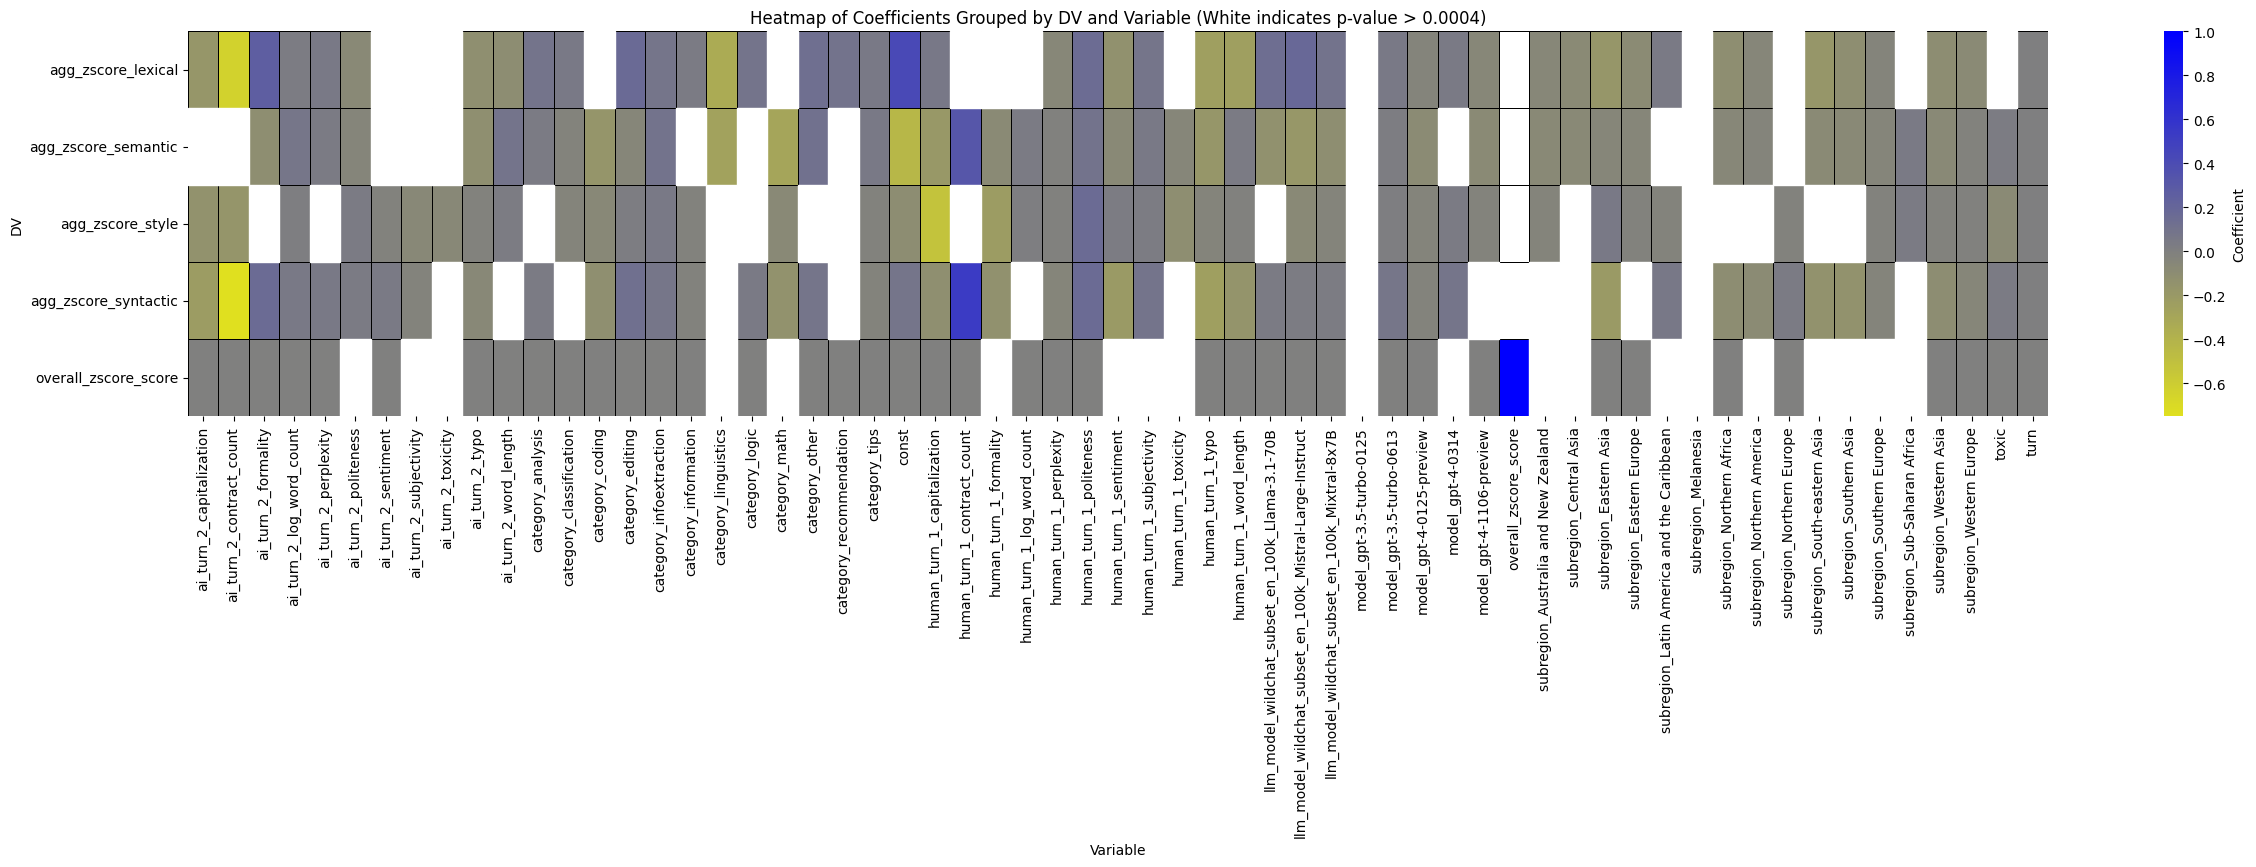

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

results_df = pd.read_csv('/shared/0/projects/research-jam-summer-2024/results/ols_results_with_ci_100k.csv')

results_df = results_df[~results_df['Variable'].str.startswith(('lda_', 'prompt'))]

matrix = results_df.pivot(index='DV', columns='Variable', values='Coefficient')
p_value_matrix = results_df.pivot(index='DV', columns='Variable', values='P-value')

cmap = LinearSegmentedColormap.from_list('two_color_cmap', ['yellow', 'blue'])  
norm = plt.Normalize(vmin=matrix.min().min(), vmax=matrix.max().max())  

mask = p_value_matrix > 0.0004

plt.figure(figsize=(30, 5)) 

ax = sns.heatmap(matrix, annot=False, cmap=cmap, norm=norm, center=0, linewidths=0.5, linecolor='black', cbar_kws={'label': 'Coefficient'})

for (i, j), val in np.ndenumerate(mask):
    if val:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color='white', zorder=2))

plt.title('Heatmap of Coefficients Grouped by DV and Variable (White indicates p-value > 0.0004)')

plt.show()
